In [40]:
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Data

In [41]:
ratings_df= pd.read_csv('ratings.csv')
user_ratings_counts = ratings_df['userId'].value_counts()
active_users = user_ratings_counts[user_ratings_counts > 10].index

ratings_df = ratings_df[ratings_df['userId'].isin(active_users)]
ratings_df=ratings_df[ratings_df['rating'] > 2]
transaction_data= ratings_df.groupby('userId')['movieId'].apply(list).reset_index()
transaction_data


,userId,movieId
0,1,"[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,..."
1,2,"[318, 333, 1704, 3578, 6874, 8798, 46970, 4851..."
2,3,"[849, 1275, 1371, 1587, 2288, 2851, 3024, 3703..."
3,4,"[21, 45, 52, 58, 106, 125, 162, 171, 176, 215,..."
4,5,"[1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232..."
...,...,...
605,606,"[1, 7, 11, 15, 17, 18, 28, 29, 32, 36, 46, 47,..."
606,607,"[1, 11, 25, 34, 36, 86, 110, 150, 153, 165, 18..."
607,608,"[1, 10, 16, 21, 31, 32, 34, 39, 47, 50, 70, 88..."
608,609,"[1, 10, 110, 116, 137, 150, 161, 185, 208, 231..."


In [42]:
train_data_dict=[]
test_data_dict=[]

for index,row in transaction_data.iterrows():
    user_id = row['userId']
    movie_ids = row['movieId']

    train_movies,test_movies=train_test_split(movie_ids,test_size=0.2,random_state=42)

    train_data_dict.append({'UserId':user_id,'MovieId':train_movies})
    test_data_dict.append({'UserId':user_id,'MovieId':test_movies})

In [43]:
train_df=pd.DataFrame(train_data_dict)
test_df=pd.DataFrame(test_data_dict)

train_data=[]
test_data=[]
for row in train_data_dict:
    train_data.append(row["MovieId"])

for row in test_data_dict:
    test_data.append(row["MovieId"])

# FP-Growth

In [44]:
class Node():
    def __init__(self,item,count,parent):
        self.item=item
        self.parent=parent
        self.count=count
        self.children={}

In [45]:
class FP_Growth():
    def __init__(self,min_conf=None,min_support=None):
        self.min_conf=min_conf
        self.min_support=min_support
        self.num_samples=None
        self.min_support_count=None

    def has_single_path(self,root):
        def num_children(node):
            return sum(1 for child in node.children.values()) 
        stack = [root]
        while stack:
            node =stack.pop()
            if(num_children(node)>1):
                return False
            stack.extend(node.children.values())
        return True
    
    def find_prefix_path(self,node):
        current_node=node.parent
        prefix_path=[]
        while current_node.item!="null":
            prefix_path.append(current_node.item)
            current_node=current_node.parent
        return prefix_path
    
    def dfs(self,node,path=[]):
        if(node.item!="null"):
            path.append(node)
        for child_item,child_node in node.children.items():
            self.dfs(child_node,path)

    def create_fp_tree(self,transaction):
        item_counts=defaultdict(int)
        if(self.num_samples==None):
            self.num_samples=len(transaction)
            self.min_support_count= int(self.num_samples*(self.min_support/100))
        for data in transaction:
            for item in data:
                item_counts[item]+=1
        
        frequent_items = {item: count for item, count in item_counts.items() if count >= self.min_support}
        frequent_items = dict(sorted(frequent_items.items(), key=lambda x: (x[1],x[0])))
        root = Node(item="null", count=0, parent= None)
        header_table = {}

        for data in transaction:
            sorted_items = []
            for item in data:
                if(item in frequent_items):
                    sorted_items.append(item)
            sorted_items.sort(key=lambda x: (frequent_items[x], x), reverse=True)
            current_node=root
            for item in sorted_items:
                if item in current_node.children:
                    current_node.children[item].count+=1
                else:
                    new_node = Node(item, 1, current_node)
                    current_node.children[item] = new_node
                    if item in header_table:
                        header_table[item].append(new_node)
                    else:
                        header_table[item]=[new_node]
                current_node=current_node.children[item]
        
        return header_table,root
    
    def mime_fp_tree(self,header_table,root,prefix=[]):
        frequent_patterns={}

        if(self.has_single_path(root)):
            path=[]
            self.dfs(root,path)
            for i in range(1,len(path)+1):
                for combination in itertools.combinations(path,i):
                    comb=list(combination)
                    support=1000000
                    for item in comb:
                        curr_count=item.count
                        if(curr_count < int(support)):
                            support=curr_count
                    comb_item=[]
                    for j in comb:
                        comb_item.append(j.item)
                    frequent_patterns[tuple(sorted(comb_item+prefix))]=support
        else:
            for item in header_table:
                support_count=0
                current_nodes=header_table[item]
                for node in current_nodes:
                    support_count+=node.count
                beta=[item] + prefix
                frequent_patterns[tuple(beta)]=support_count
                conditional_pattern_base=[]
                for node in current_nodes:
                    count=node.count
                    prefix_path=self.find_prefix_path(node)
                    for i in range(count):
                        conditional_pattern_base.append(prefix_path)
                conditional_header_table,conditional_root=self.create_fp_tree(conditional_pattern_base)

                if conditional_header_table:
                    conditional_pattern=self.mime_fp_tree(conditional_header_table,conditional_root,beta)
                    frequent_patterns.update(conditional_pattern)
        return frequent_patterns
    
    def generate_association_rules(self,frequent_items):
        association_rules=[]
        for item,support in frequent_items.items():
            l=item
            if(len(l))>1:
                for i in range(1,len(l)+1):
                    for combination in itertools.combinations(l,i):
                        s= tuple(sorted(combination))
                        set1=set(l)
                        set2=set(s)
                        diff=tuple(set1-set2)
                        if len(diff)>0:
                            conf= (frequent_items[l]/frequent_items[s])*100
                            if(conf>=self.min_conf):
                                association_rules.append([s,diff,conf,support])
        return association_rules

# Generating Frequent Sets

In [46]:
data=train_data

min_support=50
min_conf=10
fp_growth=FP_Growth(min_support=min_support,min_conf=min_conf)
header_table,root=fp_growth.create_fp_tree(data)
frequent_items= fp_growth.mime_fp_tree(header_table,root)
frequent_items={tuple(sorted(key)): value for key, value in frequent_items.items()}
frequent_items

{(356,): 238,
 (318, 356): 131,
 (593,): 216,
 (356, 593): 110,
 (318, 356, 593): 73,
 (296, 318, 356, 593): 55,
 (296, 356, 593): 76,
 (318, 593): 123,
 (296, 318, 593): 82,
 (296, 593): 126,
 (2571,): 215,
 (356, 2571): 101,
 (296, 356, 2571): 66,
 (318, 356, 2571): 62,
 (593, 2571): 96,
 (356, 593, 2571): 55,
 (296, 593, 2571): 60,
 (318, 593, 2571): 57,
 (296, 2571): 109,
 (318, 2571): 108,
 (296, 318, 2571): 67,
 (480,): 180,
 (356, 480): 112,
 (480, 593): 97,
 (356, 480, 593): 64,
 (296, 480, 593): 61,
 (480, 2571): 76,
 (260, 480, 2571): 53,
 (318, 480): 94,
 (318, 356, 480): 69,
 (318, 480, 593): 59,
 (296, 318, 480): 63,
 (260, 480): 78,
 (296, 480): 101,
 (296, 356, 480): 69,
 (110,): 179,
 (110, 356): 100,
 (110, 318, 356): 64,
 (110, 480): 98,
 (110, 356, 480): 67,
 (110, 318, 480): 56,
 (110, 296, 480): 56,
 (110, 593): 94,
 (110, 480, 593): 57,
 (110, 356, 593): 55,
 (110, 318, 593): 59,
 (110, 296, 593): 59,
 (110, 2571): 83,
 (110, 593, 2571): 50,
 (110, 318): 101,
 (11

# Generating Association Rules

In [47]:
association_rules=fp_growth.generate_association_rules(frequent_items)
association_rules

[[(318,), (356,), 52.400000000000006, 131],
 [(356,), (318,), 55.04201680672269, 131],
 [(356,), (593,), 46.21848739495798, 110],
 [(593,), (356,), 50.92592592592593, 110],
 [(318,), (593, 356), 29.2, 73],
 [(356,), (593, 318), 30.672268907563026, 73],
 [(593,), (356, 318), 33.7962962962963, 73],
 [(318, 356), (593,), 55.72519083969466, 73],
 [(318, 593), (356,), 59.34959349593496, 73],
 [(356, 593), (318,), 66.36363636363637, 73],
 [(296,), (593, 356, 318), 23.504273504273502, 55],
 [(318,), (296, 593, 356), 22.0, 55],
 [(356,), (296, 593, 318), 23.10924369747899, 55],
 [(593,), (296, 356, 318), 25.462962962962965, 55],
 [(296, 318), (593, 356), 39.285714285714285, 55],
 [(296, 356), (593, 318), 42.30769230769231, 55],
 [(296, 593), (356, 318), 43.65079365079365, 55],
 [(318, 356), (296, 593), 41.98473282442748, 55],
 [(318, 593), (296, 356), 44.71544715447154, 55],
 [(356, 593), (296, 318), 50.0, 55],
 [(296, 318, 356), (593,), 63.2183908045977, 55],
 [(296, 318, 593), (356,), 67.073

### Generating Recommendations

In [48]:
df=pd.DataFrame(association_rules,columns=["antecedents","consequents","confidence","support"])
df

,antecedents,consequents,confidence,support
0,"(318,)","(356,)",52.400000,131
1,"(356,)","(318,)",55.042017,131
2,"(356,)","(593,)",46.218487,110
3,"(593,)","(356,)",50.925926,110
4,"(318,)","(593, 356)",29.200000,73
...,...,...,...,...
4717,"(1036, 2028)","(2571,)",80.645161,50
4718,"(1036, 2571)","(2028,)",65.789474,50
4719,"(2028, 2571)","(1036,)",48.076923,50
4720,"(161,)","(457,)",66.666667,50


In [49]:
df_support=df.sort_values(by='support',ascending=False)
df_support

,antecedents,consequents,confidence,support
3827,"(318,)","(296,)",56.000000,140
3826,"(296,)","(318,)",59.829060,140
0,"(318,)","(356,)",52.400000,131
1,"(356,)","(318,)",55.042017,131
3829,"(356,)","(296,)",54.621849,130
...,...,...,...,...
2061,"(1704,)","(47,)",41.666667,50
2060,"(47,)","(1704,)",33.333333,50
2031,"(1704,)","(1210,)",41.666667,50
2030,"(1210,)","(1704,)",34.482759,50


In [50]:
df_conf=df.sort_values(by='confidence',ascending=False)
df_conf

,antecedents,consequents,confidence,support
3885,"(5952, 6377)","(7153,)",91.525424,54
3893,"(4993, 6377)","(7153,)",91.071429,51
1807,"(1240, 2028)","(2571,)",89.655172,52
3718,"(4993, 8961)","(7153,)",87.719298,50
4317,"(4226, 5952)","(7153,)",86.885246,53
...,...,...,...,...
4101,"(318,)","(858, 260)",20.000000,50
3782,"(318,)","(5349,)",20.000000,50
3958,"(318,)","(33794,)",20.000000,50
955,"(318,)","(50, 2571)",20.000000,50


### creating a dictionary to convert Movie ID to Movie Name


In [51]:
movies_df=pd.read_csv('movies.csv')
id_to_name=movies_df.set_index('movieId')['title'].to_dict()
# id_to_name['318']

### Writing to the required files

In [52]:
df_sup_100=df_support[:100]
df_conf_100=df_conf[:100]

with open("12_top100RulesBySup.txt","w") as f:
    for index,row in df_sup_100.iterrows():
        antecedents=row['antecedents']
        consequents=row['consequents']
        confidence=row['confidence']
        support=row['support']
        antecedents_name=[]
        consequents_name=[]
        for i in antecedents:
            antecedents_name.append(id_to_name[str(i)])
        for i in consequents:
            consequents_name.append(id_to_name[str(i)])
        f.write("Antecedents: "+str(antecedents_name)+"\n")
        f.write("Consequents: "+str(consequents_name)+"\n")
        f.write("Confidence: "+str(confidence)+"\n")
        f.write("Support: "+str(support)+"\n")
        f.write("\n")

with open("12_top100RulesByConf.txt","w") as f:
    for index,row in df_conf_100.iterrows():
        antecedents=row['antecedents']
        consequents=row['consequents']
        confidence=row['confidence']
        support=row['support']
        antecedents_name=[]
        consequents_name=[]
        for i in antecedents:
            antecedents_name.append(id_to_name[str(i)])
        for i in consequents:
            consequents_name.append(id_to_name[str(i)])
        f.write("Antecedents: "+str(antecedents_name)+"\n")
        f.write("Consequents: "+str(consequents_name)+"\n")
        f.write("Confidence: "+str(confidence)+"\n")
        f.write("Support: "+str(support)+"\n")
        f.write("\n")

### Joining the dataframes to get the required output and sorting by confidence finally

In [53]:
recommendations =pd.merge(df_support,df_conf,on=["antecedents","consequents"],how="inner")
recommendations.drop(columns=["confidence_x","support_x"],inplace=True,axis=0)
recommendations.columns=["antecedents","consequents","confidence","support"]
recommendations = recommendations.sort_values(by='confidence',ascending=False)
recommendations

,antecedents,consequents,confidence,support
2530,"(5952, 6377)","(7153,)",91.525424,54
3689,"(4993, 6377)","(7153,)",91.071429,51
3343,"(1240, 2028)","(2571,)",89.655172,52
4468,"(4993, 8961)","(7153,)",87.719298,50
3081,"(4226, 5952)","(7153,)",86.885246,53
...,...,...,...,...
4499,"(318,)","(5349,)",20.000000,50
4510,"(318,)","(5445,)",20.000000,50
4649,"(318,)","(48516,)",20.000000,50
4582,"(318,)","(3793,)",20.000000,50


### **Choosing singular movie recommendations**

In [54]:
recommendations=recommendations[recommendations['antecedents'].map(len)==1]
recommendations=recommendations[:100]

In [55]:
recommendations['antecedents']=recommendations['antecedents'].apply(lambda x: x[0])
recommendations


,antecedents,consequents,confidence,support
3018,1653,"(2571,)",79.104478,53
2015,6365,"(2571,)",78.873239,56
458,153,"(592,)",78.021978,71
378,1221,"(858,)",77.894737,74
637,1527,"(2571,)",77.272727,68
...,...,...,...,...
700,597,"(356,)",66.336634,67
505,1291,"(1196,)",66.037736,70
34,1198,"(2571,)",66.025641,103
617,79132,"(2959,)",66.019417,68


## Finally testing the data by varying the number of rules taken into consideration

In [56]:
avg_recalls=[]
avg_precisions=[]

for i in range(1,11):
    total_recall=0
    total_precision=0
    for j in range(len(train_data)):

        recom_set=set()
        user_data=train_data[j]
        user_test=test_data[j]

        hit =0
        
        for item in user_data:
            if item in recommendations['antecedents'].values:
                x= recommendations[recommendations['antecedents']==item]['consequents'].values[:i]
                x=set([int(tup[0]) for tup in x])
                recom_set=recom_set.union(x)
        hit=recom_set.intersection(user_test)
        recall = len(hit)/len(user_test)
        total_recall+=recall
        if len(recom_set)==0:
            precision=0
        else:  
            precision = len(hit)/len(recom_set)
        total_precision+=precision
    avg_recalls.append(total_recall*100/len(train_data))
    avg_precisions.append(total_precision*100/len(train_data))

In [57]:
t=list(range(1,11))
print(t[:1])

[1]


Text(0, 0.5, 'Recall in %')

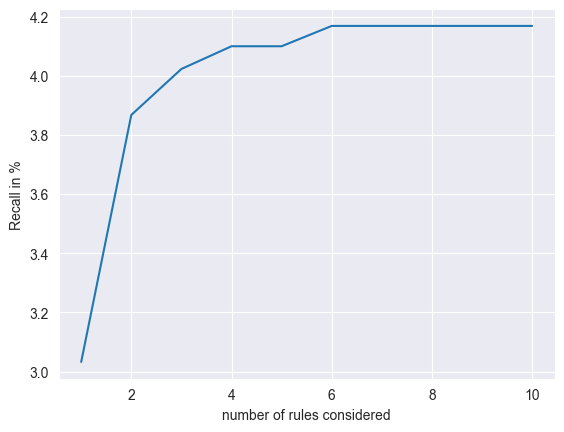

In [58]:
sns.set_style('darkgrid')

plt.plot(range(1,11),avg_recalls)
plt.xlabel('number of rules considered')
plt.ylabel('Recall in %')

Text(0, 0.5, 'Precision in %')

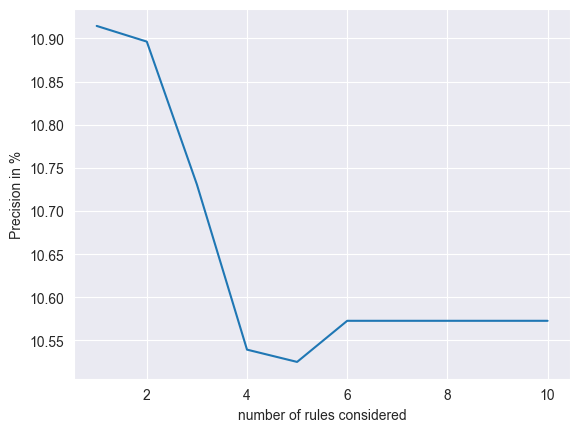

In [59]:

plt.plot(range(1,11),avg_precisions)
plt.xlabel('number of rules considered')
plt.ylabel('Precision in %')
